# Python Cheat Sheet for Geospatial Data

This notebook contains "common code" chunks that can be applied to explore and clean many geospatial datasets that're submitted for visualization on the [Permafrost Discovery Gateway](https://arcticdata.io/catalog/portals/permafrost) (PDG). The PDG is an interactive data portal for datasets related to the environment and communities in and around the Arctic region. Many of these datasets are submitted in vector or raster format, so they can be explored with `geopandas`, `rasterio`, and `matplotlib`. Sometimes the best way to explore a PDG dataset is to input a dataset sample into a simple version of the visualization workflow.

### Geodataframe Exploration and Wrangling 

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# count NA values in each column of a geodataframe
na_counts = {}
for column in gdf.columns:
    na_counts[column] = gdf[column].isna().sum()

for column, count in na_counts.items():
    print(f"Column '{column}': {count} NA values")

In [ ]:
# print the rows in gdf that have NA for the column pf_frac
rows_with_na = gdf[gdf['pf_frac'].isna()]
rows_with_na

In [ ]:
# remove the rows that have NA values in a certain attribute "TKThLP"
gdf_clean = gdf[gdf['TKThLP'].notna()]

In [ ]:
# add column that codes the categorical strings of the "EXTENT" attribute
# into numbers in order to do stats with the viz workflow

# pair the string conditions and with numerical choices, in order
conditions = [
    (gdf['EXTENT'] == "C"),
    (gdf['EXTENT'] == "D"),
    (gdf['EXTENT'] == "S"),
    (gdf['EXTENT'] == "I")
]
choices = [4, 3, 2, 1]

# create new column 
gdf['extent_code'] = np.select(conditions, choices)

In [ ]:
# explore distribution of `MultiPolygons` and singular `Polygons` in a geopackage
single_polygons = gdf[gdf.geometry.type == 'Polygon']
multipolygons = gdf[gdf.geometry.type == 'MultiPolygon']
print(f"Number of sinlge Polygon geometries: {len(single_polygons)}\nNumber of MultiPolygon geometries: {len(multipolygons)}")

In [ ]:
# subset gdf for only valid geometries
gdf_valid = gdf[gdf.geometry.is_valid]

In [ ]:
# clip geometries to the extent of other geometries
filtered_gdf = gpd.clip(gdf = gdf_valid, 
                        mask = land_valid, 
                        keep_geom_type = True)

In [ ]:
# split the cleaned data into 6 subfiles
# each file will have equal number of rows 
split_gdfs = np.array_split(data_clean, 6)

for i, split_gdf in enumerate(split_gdfs):
    split_gdf.reset_index(inplace = True)
    # Create the filename with a different number ranging from 1 to 5
    filename = f'/home/jcohen/infrastructure/data_cleaned_split/SACHI_v2_clean_{i + 1}.gpkg'
    split_gdf.to_file(filename, driver = "GPKG", index = True)
    print(f'Saved {filename}')

### Geodataframe Plotting

In [ ]:
# plot one specific geometry at location 10
gdf['geometry'][9]

In [ ]:
# plot all geometries together
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(cmap = 'viridis', linewidth = 0.8, ax = ax)

In [ ]:
# plot with palette based on the attribute "EXTENT"
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(column = 'EXTENT', 
         linewidth = 0.8,
         ax = ax, 
         cmap = 'viridis', 
         legend = True)

In [ ]:
# plot each polygon in a different color

# create a new GeoDataFrame with a 'color' column for each polygon
gdf['color'] = range(len(gdf))

# create a colormap with as many colors as there are polygons
colormap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(18, 18))

for idx, row in gdf.iterrows():
    color = colormap(row['color'] / len(gdf))
    gpd.GeoSeries(row['geometry']).plot(ax = ax, 
                                        color = color, 
                                        edgecolor = 'black')

ax.set_title("Polygons that cross the antimeridian")

# Show the plot
plt.show()

In [ ]:
# plot the gdf with one fill color and borders 

fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(ax = ax, 
         facecolor = 'blue', 
         edgecolor = 'black')

plt.title('Land Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [ ]:
# plot a bar chart to show variable distribution

gdf['variable'].value_counts().plot(kind='bar')

plt.xlabel('Attribute Values')
plt.ylabel('Count')
plt.title('Distribution of variable')
# Setting x-axis limit to a maximum value of 4
# plt.xlim(right = 4)

plt.show()

In [ ]:
# plot a histogram to show variable distribution with 10 bins

plt.hist(gdf['permanent_water'], 
         bins = 10,
         edgecolor ='black')

plt.xlabel('Binned permanent water values')
plt.ylabel('Count')
plt.title('Distribution of permanent water values')

plt.show()

In [ ]:
# plot 2 different types of geometries on top of each other: polygon and line geometries

# plot the polygon gdf first
ax = poly.plot(color = 'none', 
               edgecolor = 'red',
               facecolor = 'yellow', 
               linewidth = 0.5, 
               figsize = (13, 13))

# plot the lines on top of the polygon geometries
land.plot(ax = ax, 
          facecolor = 'none', 
          edgecolor = 'black', 
          linewidth = 1,
          figsize = (13,13))

plt.show()

### Simplest possible execution of the PDG visualization workflow with 1 input file


In [ ]:
# Simple viz-workflow script

# use env: viz_3-10_local

from datetime import datetime
import json
import logging
import logging.handlers
import os

import pdgstaging
from pdgstaging import logging_config
import pdgraster


lc = "/home/jcohen/nodata_val_testing/data/test_polygons.gpkg"

config = {
  "deduplicate_clip_to_footprint": False,
  "deduplicate_method": None,
  "dir_input": "/home/jcohen/nodata_val_testing/data/", 
  "ext_input": ".gpkg",
  "dir_staged": "/home/jcohen/nodata_val_testing/staged/", 
  "dir_geotiff": "/home/jcohen/nodata_val_testing/geotiff/",  
  "dir_web_tiles": "/home/jcohen/nodata_val_testing/web_tiles/", 
  "filename_staging_summary": "/home/jcohen/nodata_val_testing/staging_summary.csv",
  "filename_rasterization_events": "/home/jcohen/nodata_val_testing/raster_events.csv",
  "filename_rasters_summary": "/home/jcohen/nodata_val_testing/raster_summary.csv",
  "version": datetime.now().strftime("%B%d,%Y"),
  "simplify_tolerance": 0.1,
  "tms_id": "WGS1984Quad",
  "z_range": [
    0,
    11
  ],
  "geometricError": 57,
  "z_coord": 0,
  "statistics": [
    {
      "name": "change_rate", 
      "weight_by": "area",
      "property": "ChangeRateNet_myr-1", 
      "aggregation_method": "min", 
      "resampling_method": "mode",  
      "val_range": [
        -2,
        2
      ],
      "palette": ["#ff0000", # red
                  "#FF8C00", # DarkOrange
                  "#FFA07A", # LightSalmon
                  "#FFFF00", # yellow
                  "#66CDAA", # MediumAquaMarine
                  "#AFEEEE", # PaleTurquoise,
                  "#0000ff"], # blue
      "nodata_val": 999,
      "nodata_color": "#ffffff00" # fully transparent white
    },
  ],
}

print("Staging...")

stager = pdgstaging.TileStager(config = config, check_footprints = False)

# generate the staged files
stager.stage(lc)

print("Staging complete. Rasterizing...")

# -------------------------------------------------------------

# for initial testing, only rasterize the highest z-level:
# staged_paths = stager.tiles.get_filenames_from_dir(base_dir = "staged")
# rasterizer = pdgraster.RasterTiler(config)
# rasterizer.rasterize_vectors(staged_paths, make_parents = False)

# or rasterize all z-levels and web tiles:
rasterizer = pdgraster.RasterTiler(config)
rasterizer.rasterize_all()

# -------------------------------------------------------------

print("Script complete.")

## Raster plotting and exploration

In [ ]:
import rasterio
from rasterio.plot import show
import numpy as np

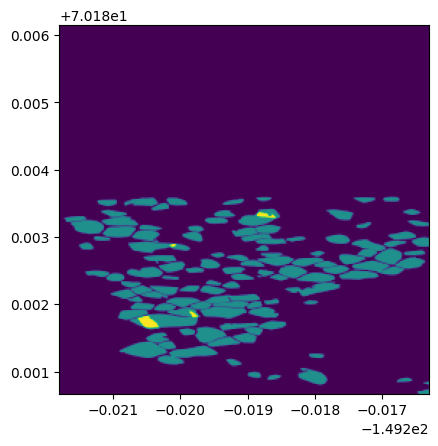

In [3]:
raster_path = "/home/jcohen/viz-info/helpful-code/geotiff/WGS1984Quad/15/5603/3607.tif"
with rasterio.open(raster_path) as src:
    show(src)

In [ ]:
# plot the raster with NA values shown (assuming there are NA values to show!)

raster_path = "/home/jcohen/nodata_val_testing/geotiff/WGS1984Quad/11/2539/255.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1) 

    # assign NA values as -999
    raster_data[np.isnan(raster_data)] = -999

    plt.figure(figsize = (10, 10))
    plt.imshow(raster_data, cmap = 'terrain')
    plt.colorbar(label = "Pixel Value")
    plt.title("Raster NA Values")

    plt.show()

In [ ]:
# get unique values in an array and their counts
# (best for arrays with a known small range of integers)
unique_values, counts = np.unique(array, return_counts = True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Frequency: {count}")

In [ ]:
# print the CRS of a raster
raster_path = "/home/jcohen/lake_change_time_series/geotiff/WGS1984Quad/11/3479/187.tif"
with rasterio.open(raster_path) as data:
    crs = data.crs
    print(crs)

## Convert a geopackage into a raster

For rasters in units of meters:

A dataset's geospatial transform is an affine transformation matrix that maps pixels in _(row,col)_ coords to _(x,y)_ spatial positions. 

If the dataset's units were in meters, the _spatial position_ of the upper left of the dataset is derived from the product of:
- (0,0) which are the row and column coords of the upper left corner of the dataset, and
- the dataset's affine transformation matrix 

In [ ]:
import geopandas as gpd

In [ ]:
# first load in a gpkg vector from lake change time series dataset 
gdf = gpd.read_file("/var/data/submission/pdg/nitze_lake_change/time_series_2023-04-05/exploded_annual_2017-2021/yr2017/merged_lakes_2017_exploded.gpkg")
gdf.crs

In [ ]:
# subset to a small number of polygons for testing
gdf_subset = gdf.iloc[:5]

In [ ]:
output_path = "/home/jcohen/vector_to_raster/lake_change_raster.tif"
width = 256
height = 256
# * is used to unpack args from a list or tuple, and gdf.total_bounds returns a tuple of min and max coords of all geoms 
transform = rasterio.transform.from_bounds(*gdf_subset.total_bounds, width, height)
transform

In [ ]:
with rasterio.open(
    output_path,
    'w',
    driver = 'GTiff',
    height = height,
    width = width,
    count = 1,
    dtype = rasterio.uint8,
    crs = gdf_subset.crs,
    transform = transform,
) as dst:
    shapes = ((geom, 255) for geom in gdf_subset.geometry)
    rasterized = features.rasterize(shapes = shapes, out_shape = (height, width), transform = transform)
    dst.write(rasterized, indexes = 1)

In [ ]:
LC_raster_path = output_path
with rasterio.open(LC_raster_path) as LC_data:
    crs = LC_data.crs
    print(crs)
    show(LC_data)